In [23]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model


model = read_sbml_model("../model/Rpom_05.xml")

https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http

In [25]:
# Load all reaction and protein data from both databases
import pickle

# Proteins
with open("../model_building/biocyc_update_pipeline/data/raw_protein_data__RUEGERIA_POMEROYI_DSS3.pkl", "rb") as f:
    proteins1 = pickle.load(f)
with open("../model_building/biocyc_update_pipeline/data/raw_protein_data__GCF_000011965.pkl", "rb") as f:
    proteins2 = pickle.load(f)
proteins1 = {protein["@frameid"]: protein for protein in proteins1}
proteins2 = {protein["@frameid"]: protein for protein in proteins2}

# Reactions
with open("../model_building/biocyc_update_pipeline/data/raw_reaction_data__RUEGERIA_POMEROYI_DSS3.pkl", "rb") as f:
    reactions1 = pickle.load(f)
with open("../model_building/biocyc_update_pipeline/data/raw_reaction_data__GCF_000011965.pkl", "rb") as f:
    reactions2 = pickle.load(f)

In [26]:
from model_building.biocyc_update_pipeline.transform.build_templates import get_gene_reaction_rule

gprs1 = pd.DataFrame(
    [
        {"ID": rxndata["@frameid"], "GPR": get_gene_reaction_rule(rxndata, proteins1)}
        for rxndata in reactions1
    ]
)

gprs2 = pd.DataFrame(
    [
        {"ID": rxndata["@frameid"], "GPR": get_gene_reaction_rule(rxndata, proteins2)}
        for rxndata in reactions2
    ]
)

In [27]:
def get_ec(rxn_data):
    temp = rxn_data.get("ec-number", {})
    if isinstance(temp, str):
        return temp.lstrip("EC-")
    elif isinstance(temp, list):
        return ", ".join([elem.lstrip("EC-") if isinstance(elem, str) else elem.get("#text", "").lstrip("EC-") for elem in temp])
    elif isinstance(temp, dict):
        return temp.get("#text", "").lstrip("EC-")
    else:
        raise ValueError("Invalid type")

ec_db1 = pd.DataFrame([{"ID": rxn["@frameid"],
               "EC DB1": get_ec(rxn)}
              for rxn in reactions1])

ec_db2 = pd.DataFrame([{"ID": rxn["@frameid"],
               "EC DB2": get_ec(rxn)}
              for rxn in reactions2])

In [28]:
# Filter to reactions that are
# 1) in the model, and
# 2) with no genes in either DB.

all_gprs = gprs1.merge(gprs2, left_on="ID", right_on="ID", suffixes=[" db1", " db2"], how="outer")
gprs_in_model = all_gprs[[rxnid in model.reactions for rxnid in all_gprs["ID"]]]

gap_filled_in_model = gprs_in_model[[
    (pd.isna(gpr1) or gpr1 == "()") and (pd.isna(gpr2) or gpr2 == "()")
    for _, (_, gpr1, gpr2) in gprs_in_model.iterrows()
]]

(array([ 13.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0.        , 0.02873522, 0.05747043, 0.08620565, 0.11494087,
        0.14367609, 0.1724113 , 0.20114652, 0.22988174, 0.25861695,
        0.28735217, 0.31608739, 0.34482261, 0.37355782, 0.40229304,
        0.43102826, 0.45976348, 0.48849869, 0.51723391, 0.54596913,
        0.57470434]),
 <BarContainer object of 20 artists>)

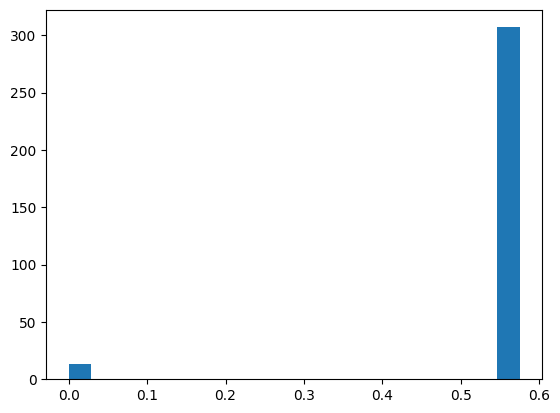

In [29]:
# Rank by growth impact of deletion on glucose growth
with model:
    model.reactions.get_by_id("EX_glc").bounds = (-5.44, 0)

    baseline_mu = model.optimize()

    growth_rates = {}
    for rxn in gap_filled_in_model["ID"]:
        with model:
            model.reactions.get_by_id(rxn).bounds = (0.,0.)
            growth_rates[rxn] = model.optimize().objective_value


fig, ax = plt.subplots()
ax.hist(growth_rates.values(), bins=20)

In [30]:
growth_ranked = gap_filled_in_model.copy()

# Links to biocyc
growth_ranked = growth_ranked.merge(pd.DataFrame([
    {"ID": rxnid,
     "Link DB1": f"https://biocyc.org/reaction?orgid=RUEGERIA_POMEROYI_DSS3&id={rxnid}",
     "Link DB2" : f"https://biocyc.org/reaction?orgid=GCF_000011965&id={rxnid}"}
    for rxnid in growth_ranked["ID"]]),
    left_on="ID", right_on="ID")

# EC numbers
growth_ranked = growth_ranked.merge(ec_db1, on="ID").merge(ec_db2, on="ID")

# Model data
growth_ranked = growth_ranked.merge(pd.DataFrame([{"ID" : rxn, "mu" : mu} for rxn, mu in growth_rates.items()]),
             left_on="ID", right_on="ID")
growth_ranked["Flux"] = [baseline_mu[rxn] for rxn in growth_ranked["ID"]]
growth_ranked["Abs Flux"] = growth_ranked["Flux"].abs()
growth_ranked["Fold-Change"] = growth_ranked["mu"] / baseline_mu.objective_value
growth_ranked = growth_ranked.sort_values("Abs Flux", ascending=False).sort_values("Fold-Change")
growth_ranked

,ID,GPR db1,GPR db2,Link DB1,Link DB2,EC DB1,EC DB2,mu,Flux,Abs Flux,Fold-Change
59,SUCCINYLDIAMINOPIMTRANS-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,2.6.1.17,2.6.1.17,0.000000,0.164300,0.164300,0.0
102,RXN0-2382,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,4.2.1.122,4.2.1.122,0.000000,0.027146,0.027146,0.0
20,RXN0-2381,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,4.1.2.8,4.1.2.8,0.000000,0.027146,0.027146,0.0
79,H2NEOPTERINP3PYROPHOSPHOHYDRO-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,3.6.1.67,3.6.1.67,0.000000,0.000384,0.000384,0.0
38,DIHYDRONEOPTERIN-MONO-P-DEPHOS-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,3.6.1,3.6.1,0.000000,0.000384,0.000384,0.0
...,...,...,...,...,...,...,...,...,...,...,...
34,THREOSPON-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,,,0.574704,0.000000,0.000000,1.0
29,RXN-12721,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,1.8.4.9,1.8.4.9,0.574704,0.000000,0.000000,1.0
32,RXN-18205,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,,,0.574704,0.000000,0.000000,1.0
33,RXN-12865,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,1.8.1,1.8.1,0.574704,0.000000,0.000000,1.0


Now let's add links to KEGG genes with corresponding ECs, if they exist:

In [31]:
# Utility class to query KEGG
import datetime
import time
import requests
import re

class PoliteKEGGer():
    last_query_time = None
    delay = datetime.timedelta(seconds=1/3)
    cache = {}

    def make_request(self, url, raise_for_status=True, verbose=False):
        if url in self.cache:
            return self.cache[url]
        
        # Be polite
        dt = (datetime.datetime.now() - self.last_query_time
              if not self.last_query_time is None
              else datetime.timedelta(seconds=1e12))
        if dt < self.delay:
            if verbose:
                print("zzz...")
            time.sleep(dt.total_seconds())

        response = requests.get(url)
        if raise_for_status:
            response.raise_for_status()

        self.last_query_time = datetime.datetime.now()

        self.cache[url] = response

        return response


    def query_kegg_by_ec(self, ec_number, organism='sil', verbose=False):
        """
        Query KEGG for a given EC number in the specified organism.
        
        Parameters:
        ec_number (str): The enzyme commission number to query.
        organism (str): The organism code (default is 'sil').
        
        Returns:
        ...
        """
        # Construct the KEGG API URL
        ec_number = ec_number.strip()
        url = f'http://rest.kegg.jp/find/{organism}/{ec_number}'
        
        # Get all matching genes. Since matching is by substring,
        # something like 1.1.1.107 will match to query 1.1.1.1,
        # so we'll need to do additional filtering.
        try:
            # Send a GET request to the KEGG API
            response = self.make_request(url, verbose=verbose)
            
            # Process the response
            results = response.text.strip().split('\n')
            
            # Get all genes returned by search
            gene_ids = []
            for line in results:
                if line == "":
                    continue

                gene_id, _ = line.split('\t')
                gene_ids.append(gene_id)
        
        except requests.RequestException as e:
            return f"An error occurred: {e}"

        filtered_genes = []
        for gene_id in gene_ids:
            # Get full db entry with all info for gene
            response = self.make_request(f"http://rest.kegg.jp/get/{gene_id}", verbose=verbose)
            results = response.text.strip().split('\n')
            
            for line in results:
                if line.startswith("ORTHOLOGY"):
                    match_result = (re.search(r"ORTHOLOGY\W*(?P<ko>K\d+)[\W\w]+\[EC:(?P<ecs>(?:\d[\.(?:\d+|\-)]+ ?)+)\]", line))
                    break

            # ko = match_result["ko"]
            ecs = match_result["ecs"]

            if ec_number in ecs.split():
                filtered_genes.append(gene_id)
        
        return filtered_genes

In [32]:
from tqdm import tqdm
polite_kegg= PoliteKEGGer()

In [34]:
with_kegg = growth_ranked.copy()
with_kegg["KEGG"] = [
    ", ".join(
    [polite_kegg.query_kegg_by_ec(ec) if ec != "" else [""]
     for ec in (set(ec1.split(", ")) | set(ec2.split(", ")))][0])
    for _, (ec1, ec2) in tqdm(growth_ranked[["EC DB1", "EC DB2"]].iterrows(),
                              total=len(growth_ranked))
]
with_kegg

100%|██████████| 120/120 [03:50<00:00,  1.92s/it]


,ID,GPR db1,GPR db2,Link DB1,Link DB2,EC DB1,EC DB2,mu,Flux,Abs Flux,Fold-Change,KEGG
59,SUCCINYLDIAMINOPIMTRANS-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,2.6.1.17,2.6.1.17,0.000000,0.164300,0.164300,0.0,sil:SPO0962
102,RXN0-2382,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,4.2.1.122,4.2.1.122,0.000000,0.027146,0.027146,0.0,
20,RXN0-2381,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,4.1.2.8,4.1.2.8,0.000000,0.027146,0.027146,0.0,
79,H2NEOPTERINP3PYROPHOSPHOHYDRO-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,3.6.1.67,3.6.1.67,0.000000,0.000384,0.000384,0.0,sil:SPO0803
38,DIHYDRONEOPTERIN-MONO-P-DEPHOS-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,3.6.1,3.6.1,0.000000,0.000384,0.000384,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...
34,THREOSPON-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,,,0.574704,0.000000,0.000000,1.0,
29,RXN-12721,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,1.8.4.9,1.8.4.9,0.574704,0.000000,0.000000,1.0,
32,RXN-18205,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,,,0.574704,0.000000,0.000000,1.0,
33,RXN-12865,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,1.8.1,1.8.1,0.574704,0.000000,0.000000,1.0,


In [ ]:
with_kegg.to_clipboard(index=False)

In [ ]:
result.sort_values("Abs Flux", ascending=False).sort_values("Fold-Change").to_clipboard(index=False)

NameError: name 'result' is not defined

Can we try like, order 2 KOs? So:
1. First try taking fold-changes for single KOs
2. Next, take ONLY reactions with fold-change 1, and do double-KOs

In [ ]:
from itertools import combinations
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import io

_WORKER_MODEL = None
_EX_RXN_ID = None
_BASELINE = None

def _init_worker(model_json_str, ex_rxn_id, baseline_value):
    # Rebuild a private model copy in each worker
    global _WORKER_MODEL, _EX_RXN_ID, _BASELINE
    from cobra.io import load_json_model
    _EX_RXN_ID = ex_rxn_id
    _BASELINE = baseline_value
    # Load model from JSON string into this process
    _WORKER_MODEL = load_json_model(io.StringIO(model_json_str))

def _eval_pair(pair_ids):
    # pair_ids is a tuple of two reaction IDs
    rxn1_id, rxn2_id = pair_ids
    with _WORKER_MODEL as m:
        m.reactions.get_by_id(_EX_RXN_ID).bounds = (-5.44, 0)
        m.reactions.get_by_id(rxn1_id).bounds = (0.0, 0.0)
        m.reactions.get_by_id(rxn2_id).bounds = (0.0, 0.0)
        mu = m.slim_optimize()
    return (frozenset(pair_ids), mu / _BASELINE)


# 1) Single KOs
single_fcs = {}
for reaction in tqdm(model.reactions):
    if (reaction in model.exchanges
        or "tex" in reaction.id
        or "tpp" in reaction.id
        or "TRANS-RXN" in reaction.id):
        continue
    
    with model:
        model.reactions.get_by_id("EX_glc").bounds = (-5.44, 0)

        reaction.bounds = (0., 0.)
        ko_mu = model.slim_optimize()
        single_fcs[reaction] = (ko_mu / baseline_mu.objective_value)

# 2) Filter to non-essential (fc ≈ 1) and switch to IDs for parallel safety
keep_ids = [rxn.id for rxn, fc in single_fcs.items() if abs(fc - 1.0) <= 1e-5]
n = len(keep_ids)
total_pairs = n * (n - 1) // 2

# 3) Serialize the model once for workers
# If COBRApy >= 0.24 supports model.to_json(), this works:
# model_json_str = model.to_json()  # alternative: from cobra.io import to_json; model_json_str = to_json(model)
from cobra.io import to_json; model_json_str = to_json(model)

# 4) Parallel double KOs
double_fcs = {}
pair_iter = combinations(keep_ids, 2)

# Choose a reasonable chunksize; tune for your machine/problem
chunksize = 64

with Pool(processes=cpu_count(),
          initializer=_init_worker,
          initargs=(model_json_str, "EX_glc", baseline_mu.objective_value)) as pool:
    for key, val in tqdm(pool.imap_unordered(_eval_pair, pair_iter, chunksize=chunksize),
                         total=total_pairs):
        double_fcs[key] = val

# double_fcs now contains frozenset({rxn1_id, rxn2_id}) -> fitness change


  0%|          | 0/1850 [00:00<?, ?it/s]

100%|██████████| 890445/890445 [03:59<00:00, 3717.30it/s]


In [ ]:
double_kos_df = pd.DataFrame(
    [
        {"Reaction 1": r1,
         "Reaction 2": r2,
         "GPR 1": model.reactions.get_by_id(r1).gene_reaction_rule,
         "GPR 2": model.reactions.get_by_id(r2).gene_reaction_rule,
         "FC" : fc}
         for (r1, r2), fc in double_fcs.items()
         if abs(fc - 1) >= 1e-5
    ]
)
double_kos_df.sort_values("FC").to_clipboard(index=False)

In [ ]:
res

Reaction identifier,CATAL-RXN
Name,CATAL-RXN
Memory address,0x792f99a7e690
Stoichiometry,2.0 HYDROGEN-PEROXIDE[c] --> OXYGEN-MOLECULE[c] + 2.0 WATER[c] 2.0 hydrogen peroxide --> oxygen + 2.0 H2O
GPR,SPOA0061
Lower bound,0.0
Upper bound,1000.0
